# Movie Recommendation on Apache Spark

NathanLVZS


## Dataset strcture

the rating dataset: UserID, MovieID, Rating, Timestamp

the extracted small rating dataset: UserID, MovieID, Rating

the movies dataset: MovieID, Title, Genres


In [1]:
import os
import sys
import time
import math
from test_helper import Test
import matplotlib.pyplot as plt

baseDir = os.path.join('data')
ratingFilename = os.path.join(baseDir, 'ratings_small.csv')
movieFilename = os.path.join(baseDir, 'movies.csv')


## Preparation and Basic Analyses



In [2]:
numPartition = 2
rawRatings = sc.textFile(ratingFilename).repartition(numPartition)
rawMovies = sc.textFile(movieFilename)
movieHeader = rawMovies.first()
rawMovies = rawMovies.filter(lambda x: x != movieHeader)

def getRatingTuple(line):
    items = line.replace("\n", "").split(",")
    try:
        return int(items[0]), int(items[1]), float(items[2])
    except ValueError:
        pass

def getMovieTuple(line):
    items = line.replace("\n", "").split(",")
    try:
        return int(items[0]), items[1]
    except ValueError:
        pass

ratingsRDD = rawRatings.map(getRatingTuple).cache()
moviesRDD = rawMovies.map(getMovieTuple).cache()

ratingsCount = ratingsRDD.count()
moviesCount = moviesRDD.count()

print 'There are %s ratings and %s movies in the small dataset' % (ratingsCount, moviesCount)
# There are 141191 ratings and 27278 movies in the small dataset
print 'Ratings: %s' % ratingsRDD.take(3)
print 'Movies: %s' % moviesRDD.take(3)


There are 141191 ratings and 27278 movies in the small dataset
Ratings: [(1, 223, 3.0), (1, 587, 5.0), (1, 1257, 2.0)]
Movies: [(1, u'Toy Story (1995)'), (2, u'Jumanji (1995)'), (3, u'Grumpier Old Men (1995)')]


### Some statistics about the whole rating dataset


average rating of the whole dataset: 3.54


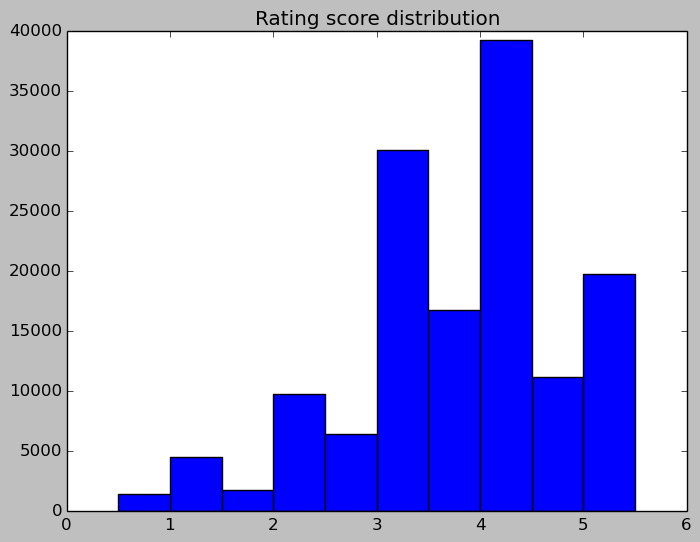

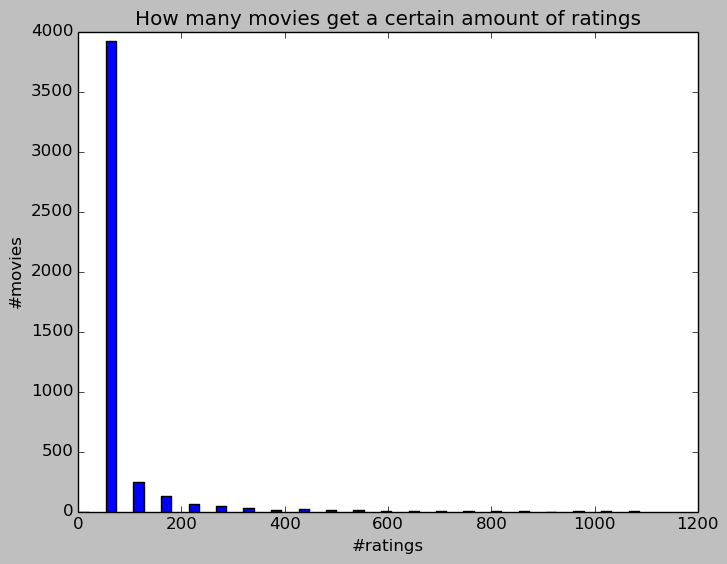

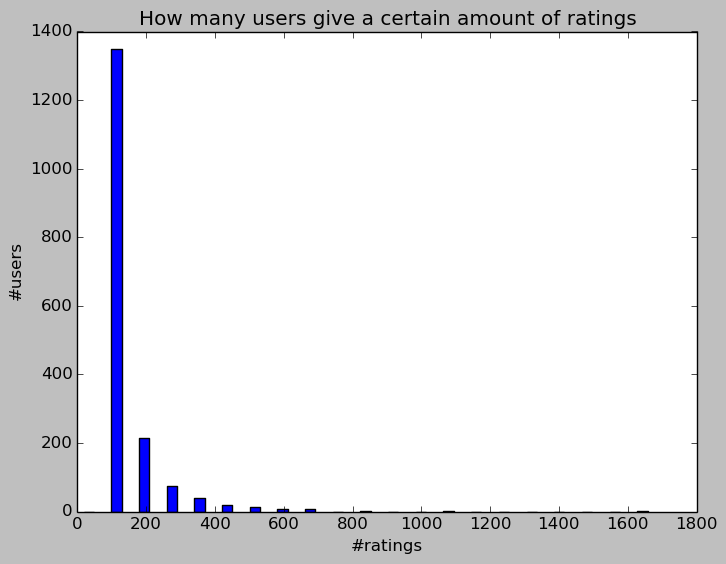

In [3]:

# rating score distribution
def get_rating_distribution(ratingRDD):
    return ratingRDD.map(lambda x: (x[2], 1)).countByKey().items()

ratingscoreDict = {x[0]:x[1] for x in get_rating_distribution(ratingsRDD)}
# print ratingscoreDict
plt.figure()
plt.bar(ratingscoreDict.keys(), ratingscoreDict.values(), 0.5)
plt.title('Rating score distribution')
# compute the average rating score of the whole dataset
avgrating = sum([k * ratingscoreDict[k] for k in ratingscoreDict]) / sum(ratingscoreDict.values())
print "average rating of the whole dataset: %.2f" % avgrating

# movie - number of ratings distribution
def getMovieRatingDistribution(ratingRDD):
    tempdict = ratingRDD.map(lambda x: (x[1], 1)).countByKey()
    return sc.parallelize(tempdict.values()).histogram(20)

movieratedDict = getMovieRatingDistribution(ratingsRDD)
# print movieratedDict
plt.figure()
plt.bar([int(x) for x in movieratedDict[0]], [0] + movieratedDict[1], 20)
plt.xlabel('#ratings')
plt.ylabel('#movies')
plt.title('How many movies get a certain amount of ratings')

def getUserRatingDistribution(ratingRDD):
    tempdict = ratingRDD.map(lambda x: (x[0], 1)).countByKey()
    return sc.parallelize(tempdict.values()).histogram(20)

userratedDict = getUserRatingDistribution(ratingsRDD)
# print userratedDict
plt.figure()
plt.bar([int(x) for x in userratedDict[0]], [0] + userratedDict[1], 30)
plt.xlabel('#ratings')
plt.ylabel('#users')
plt.title('How many users give a certain amount of ratings')


In [4]:
def getRatingDistributionOfAMovie(ratingRDD, movieID):
    """ Get the rating distribution of a specific movie
    Args:
        ratingRDD: a RDD containing tuples of (UserID, MovieID, Rating)
        movieID: the ID of a specific movie
    Returns:
        [(rating score, number of this rating score)]
    """
    return ratingRDD.filter(lambda x: x[1] == movieID).map(lambda x: (x[2], 1)).countByKey()

def getRatingDistributionOfAUser(ratingRDD, userID):
    """ Get the rating distribution of a specific user
    Args:
        ratingRDD: a RDD containing tuples of (UserID, MovieID, Rating)
        userID: the ID of a specific user
    Returns:
        [(rating score, number of this rating score)]
    """
    return ratingRDD.filter(lambda x: x[0] == userID).map(lambda x: (x[2], 1)).countByKey()

print getRatingDistributionOfAMovie(ratingsRDD, 587)
print getRatingDistributionOfAUser(ratingsRDD, 1)


defaultdict(<type 'int'>, {3.5: 41, 4.5: 10, 2.0: 39, 3.0: 149, 4.0: 142, 5.0: 73, 2.5: 26, 1.0: 9, 1.5: 7, 0.5: 6})
defaultdict(<type 'int'>, {2.0: 3, 3.0: 7, 4.0: 7, 5.0: 6})


### Split the Dataset



In [5]:
# set seeds
seeds = range(10)


## Error Measurement

We will use the Root Mean Square Error (RMSE) and Mean Absolute Error (MAE) to measure prediction error. 


In [6]:

def computeErrors(predictedRDD, actualRDD):
    """ Compute the RMSE and MAE between predicted and actual RDD
    Args:
        predictedRDD: predicted ratings for each movie and each user where each entry is in the form
                      (UserID, MovieID, Rating)
        actualRDD: actual ratings where each entry is in the form (UserID, MovieID, Rating)
    Returns:
        (RMSE, MAE)
        RMSE (float): computed RMSE value
        MAE (float): computed MAE value
    """
    # Transform predictedRDD into the tuples of the form ((UserID, MovieID), Rating)
    predictedReformattedRDD = predictedRDD.map(lambda rec: ((rec[0], rec[1]), rec[2]))
    # Transform actualRDD into the tuples of the form ((UserID, MovieID), Rating)
    actualReformattedRDD = actualRDD.map(lambda rec: ((rec[0], rec[1]), rec[2]))
    # Join the two RDD
    joinedRDD = predictedReformattedRDD.join(actualReformattedRDD)
    # Errors
    squaredErrorsRDD = joinedRDD.map(lambda x: (x[1][0] - x[1][1])*(x[1][0] - x[1][1]))
    absErrorsRDD = joinedRDD.map(lambda x: abs(x[1][0] - x[1][1]))
    # Compute the total error
    totalSquareError = squaredErrorsRDD.reduce(lambda v1, v2: v1 + v2)
    totalAbsoluteError = absErrorsRDD.reduce(lambda v1, v2: v1 + v2)
    # Count the number of entries for which you computed the total squared error
    numRatings = squaredErrorsRDD.count()
    return (math.sqrt(float(totalSquareError) / numRatings), float(totalAbsoluteError) / numRatings)


## Baseline

Use the average rating from a user to predict the ratings of those movies that he or she hasn’t watched. Compute the error to be compared with other methods.

As for recommendation, for this baseline method, we always recommend those movies with the highest average rating and more than certain number of ratings. 

In this part, we will use Spark to find the name, number of ratings, and the average rating of the 20 movies with the highest average rating and more than 100 ratings. We need to filter out those movies with high average rating score but no more than 100 ratings because they may not have broad appeal to everyone. 

In [7]:
def calcUserMeanRating(userRatingGroup):
    """ Calculate the average rating of a user
    """
    userID = userRatingGroup[0]
    ratingSum = 0.0
    ratingCnt = len(userRatingGroup[1])
    if ratingCnt == 0:
        return (userID, 0.0)
    for item in userRatingGroup[1]:
        ratingSum += item[1]
    return (userID, 1.0 * ratingSum / ratingCnt)

Test.assertEquals(calcUserMeanRating((123, [(1, 1), (2, 2), (3, 3)])), 
                  (123, 2.0), 'incorrect calcUserMeanRating()')


1 test passed.


In [8]:
def broadcastUserRatingAvg(sContext, uRRDDTrain):
    """ Broadcast the user average rating RDD
    """
    userRatingAvgList = uRRDDTrain.map(lambda x: calcUserMeanRating(x)).collect()
    userRatingAvgDict = {}
    for (user, avgscore) in userRatingAvgList:
        userRatingAvgDict[user] = avgscore
    uRatingAvgBC = sContext.broadcast(userRatingAvgDict)# broadcast
    return uRatingAvgBC

def predictUsingAvg(tup, avgDict):
    """ Predict using user's average rating
    """
    user, movie = tup[0], tup[1]
    avgrate = avgDict.get(user, 0.0)
    return (user, movie, avgrate)

baselineErrors = [0] * len(seeds)
err = 0
for seed in seeds:
    trainingRDD, validationRDD, testRDD = ratingsRDD.randomSplit([6, 2, 2], seed=seed)
    trainingRDD = trainingRDD.union(validationRDD)
    # (user, [(movie, rating)])
    userRatingRDDTrain = trainingRDD.map(lambda x: (x[0], (x[1], x[2]))).groupByKey()

    userRatingAvgBC = broadcastUserRatingAvg(sc, userRatingRDDTrain)
    # print 'show some values in userRatingAvgBC: %s' % userRatingAvgBC.value.get(1, 0)
    testForPredictingRDD = testRDD.map(lambda x: (x[0], x[1]))
    predictedAvgRDD = testForPredictingRDD.map(
            lambda x: predictUsingAvg(x, userRatingAvgBC.value))
    baselineErrors[err] = computeErrors(predictedAvgRDD, testRDD)
    err += 1
    # print 'predictedAvgRDD take 3: %s' % predictedAvgRDD.take(3)

blRMSEs, blMAEs = [x[0] for x in baselineErrors], [x[1] for x in baselineErrors]
print "Baseline Approach -- Average RMSE on test set: %f" % (sum(blRMSEs)/float(len(blRMSEs)))
print "Baseline Approach -- Average MAE on test set: %f" % (sum(blMAEs)/float(len(blMAEs)))


Baseline Approach -- Average RMSE on test set: 0.952338
Baseline Approach -- Average MAE on test set: 0.740086


### Baseline Recommendation


In [9]:
def getCountsAndAverages(IDandRatingsTuple):
    """ Calculate average rating
    Args:
        IDandRatingsTuple: a single tuple of (MovieID, (Rating1, Rating2, Rating3, ...))
    Returns:
        tuple: a tuple of (MovieID, (number of ratings, averageRating))
    """
    rateCnt = len(IDandRatingsTuple[1])
    return (IDandRatingsTuple[0], (rateCnt, float(sum(IDandRatingsTuple[1]))/rateCnt))

# movies with highest average ratings and more than XX ratings
# movIDRatingsRDD: (movID, [ratings])
movIDRatingsRDD = ratingsRDD.map(lambda x: (x[1], x[2])).groupByKey()
# movAvgRatingCntRDD: (movID, (number of ratings, avg rating))
movAvgRatingCntRDD = movIDRatingsRDD.map(getCountsAndAverages)
# movNameAvgRatingCntRDD: (avg rating, movName, number of ratings)
movNameAvgRatingCntRDD = (moviesRDD
                              .join(movAvgRatingCntRDD).map(lambda x: (x[1][1][1], x[1][0], x[1][1][0])))

# movLimitedAndSortedRDD: (avg rating, movName, number of ratings)
movLimitedAndSortedRDD = movNameAvgRatingCntRDD.filter(lambda x: x[2] > 100).sortBy(lambda x: x[0], False)

print 'Baseline Approach -- Recommend movies with highest average rating and more than 100 ratings\n'
print '\n'.join(map(str, movLimitedAndSortedRDD.take(30)))

Baseline Approach -- Recommend movies with highest average rating and more than 100 ratings

(4.44206008583691, u'Seven Samurai (Shichinin no samurai) (1954)', 233)
(4.441028225806452, u'"Shawshank Redemption', 992)
(4.344101123595506, u'"Godfather', 712)
(4.301353013530135, u"Schindler's List (1993)", 813)
(4.299171842650104, u'"Godfather: Part II', 483)
(4.288288288288288, u'Lawrence of Arabia (1962)', 222)
(4.274324324324325, u'"Dark Knight', 370)
(4.228448275862069, u'Star Wars: Episode IV - A New Hope (1977)', 928)
(4.224105461393597, u"One Flew Over the Cuckoo's Nest (1975)", 531)
(4.217021276595744, u'Inception (2010)', 235)
(4.208154506437769, u'"Matrix', 932)
(4.192776735459662, u'Pulp Fiction (1994)', 1066)
(4.182868142444659, u'"Silence of the Lambs', 1039)
(4.182142857142857, u'Casablanca (1942)', 420)
(4.181654676258993, u'"Good', 278)
(4.179389312977099, u'Arsenic and Old Lace (1944)', 131)
(4.178571428571429, u'To Kill a Mockingbird (1962)', 266)
(4.169117647058823, u'Co

## User-based



In [10]:

def constructCommonRating(tup1, tup2):
    """
    Args:
        tup1 and tup2 are of the form (user, [(movie, rating)])
    Returns: 
        ((user1, user2), [(rating1, rating2)])
    """
    user1, user2 = tup1[0], tup2[0]
    mrlist1 = sorted(tup1[1])
    mrlist2 = sorted(tup2[1])
    ratepair = []
    index1, index2 = 0, 0
    while index1 < len(mrlist1) and index2 < len(mrlist2):
        if mrlist1[index1][0] < mrlist2[index2][0]:
            index1 += 1
        elif mrlist1[index1][0] == mrlist2[index2][0]:
            ratepair.append((mrlist1[index1][1], mrlist2[index2][1]))
            index1 += 1
            index2 += 1
        else:
            index2 += 1
    return ((user1, user2), ratepair)

Test.assertEquals(constructCommonRating(
        (1, [(9, 3.0), (2, 4.0), (1, 3.0), (6, 2.0), (7, 3.5), (5, 2.5)]), 
        (2, [(7, 3.0), (3, 4.0), (6, 3.0), (5, 2.0), (2, 3.0), (8, 4.0)])), 
                  ((1, 2), [(4.0, 3.0), (2.5, 2.0), (2.0, 3.0), (3.5, 3.0)]),
                            'incorrect constructCommonRating()')

def makeUserPair(record):
    """
    Args:
        record: (movie, [(user, rating)])
    Returns:
        [((user1, user2), (rating1, rating2))]
    """
    ll = sorted(record[1], key=lambda x: x[0])
    length = len(ll)
    pairs = []
    for i in range(0, length-1):
        for j in range(i+1, length):
            pairs.append(((ll[i][0], ll[j][0]), (ll[i][1], ll[j][1])))
    return pairs

Test.assertEquals(makeUserPair((1, [(4, 4), (1, 1), (2, 2), (3, 3)])), 
                  [((1, 2), (1, 2)), ((1, 3), (1, 3)), ((1, 4), (1, 4)), 
                   ((2, 3), (2, 3)), ((2, 4), (2, 4)), ((3, 4), (3, 4))],
                            'incorrect makeUserPair()')

def constructUserMovieHist(userRatingGroup):
    """ Construct the rating list of a user
    Returns:
        (user, ([movie], [rating]))
    """
    userID = userRatingGroup[0]
    movieList = [item[0] for item in userRatingGroup[1]]
    ratingList = [item[1] for item in userRatingGroup[1]]
    return (userID, (movieList, ratingList))


1 test passed.
1 test passed.


In [11]:
def calcCosineSimilarity(tup):
    """ Compute cosine similarity
    Args:
        tup: ((user1, user2), [(rating1, rating2)])
    Returns:
        ((user1, user2), (similarity, number of common ratings))
    """
    dotproduct = 0.0
    sqsum1, sqsum2, cnt = 0.0, 0.0, 0
    for rpair in tup[1]:
        dotproduct += rpair[0] * rpair[1]
        sqsum1 += (rpair[0]) ** 2
        sqsum2 += (rpair[1]) ** 2
        cnt += 1
    denominator = math.sqrt(sqsum1) * math.sqrt(sqsum2)
    similarity = (dotproduct / denominator) if denominator else 0.0
    return (tup[0], (similarity, cnt))


In [12]:
def keyOnUser(record):
    """
    Args:
        record: ((user1, user2), (similarity, #movies both rated))
    Returns:
        [(user1, (user2, similarity, #movies both rated)), (user2, (user1, similarity, #movies both rated))]
    """
    return [(record[0][0], (record[0][1], record[1][0], record[1][1])), 
            (record[0][1], (record[0][0], record[1][0], record[1][1]))]

def getTopKSimilarUser(user, records, numK = 200):
    """
    Args:
        user: id of a user
        records: [(user_sim, similarity, number of common ratings)]
        numK: number of similar users we want to keep track of
    Returns:
        (user, [(user_sim, similarity, number of common ratings)])
    """
    llist = sorted(records, key=lambda x: x[1], reverse=True)
    llist = [x for x in llist if x[2] > 9]# filter out those whose cnt is small
    return (user, llist[:numK])


In [13]:
def broadcastUMHist(sContext, uRRDDTrain):
    """ Broadcast user movie history dict
    """
    userMovieHistList = uRRDDTrain.map(lambda x: constructUserMovieHist(x)).collect()
    userMovieHistDict = {}
    for (user, mrlistTuple) in userMovieHistList:
        userMovieHistDict[user] = mrlistTuple
    uMHistBC = sContext.broadcast(userMovieHistDict)# broadcast
    return uMHistBC

def broadcastUNeighborDict(sContext, uNeighborRDD):
    """ Broadcast user neighbors dict
    """
    userNeighborList = uNeighborRDD.collect()
    userNeighborDict = {}
    for user, simrecords in userNeighborList:
        userNeighborDict[user] = simrecords
    uNeighborBC = sContext.broadcast(userNeighborDict)# broadcast
    return uNeighborBC

def tuneK(val4PredictRDD, validationRDD, userNeighborDict, userMovieHistDict, userRatingAvgDict, top_k):
    """ Predict ratings on validation set using different size of neighborhood
    Returns:
        errors: a list containing (RMSE, MAE) corresponding to different size of neighborhood
    """
    errors = [0] * len(top_k)
    err = 0
    for numK in top_k:
        predictedRatingsRDD = val4PredictRDD.map(
            lambda x: predictUserBased(x, userNeighborDict, userMovieHistDict, userRatingAvgDict, numK)).cache()
        errors[err] = computeErrors(predictedRatingsRDD, validationRDD)
        err += 1
    return errors


### Tune the size of neighborhood



In [14]:

def predictUserBased(tup, neighborDict, usermovHistDict, avgDict, topK):
    """ Predict rating based on User Based approach
    Args:
        tup: (user, movie)
        neighborDict: (user, [(user_sim, similarity, #movies both rated)])
        usermovHistDict: (user:([movie], [rating]))
        avgDict: dict, (user:average rating score)
        topK: the number of neighbors used to predict tup[0] rating on tup[1]
    """
    user, movie = tup[0], tup[1]
    avgrate = avgDict.get(user, 0.0)
    cnt = 0
    simsum = 0.0 # sum of similarity
    weightedratingsum = 0.0
    neighbors = neighborDict.get(user, None)
    if neighbors:
        for record in neighbors:
            if cnt >= topK:
                break
            cnt += 1
            mrlistpair = usermovHistDict.get(record[0])
            if mrlistpair is None:
                continue
            index = -1
            try:
                index = mrlistpair[0].index(movie)
            except ValueError:# if error, then this neighbor hasn't rated the movie yet
                continue
            if index != -1:
                neighborAvg = avgDict.get(record[0], 0.0)
                simsum += abs(record[1])
                # (rating - average rating from this neighbor) * similarity
                weightedratingsum += (mrlistpair[1][index] - neighborAvg) * record[1]
    predRating = (avgrate + weightedratingsum / simsum) if simsum else avgrate
    return (user, movie, predRating)


In [15]:
# seeds = range(2)#test
ubValErrors = [0] * len(seeds)
top_k = range(30, 201, 10)
err = 0

for seed in seeds:
    start_time = time.time()
    # split data
    trainingRDD, validationRDD, testRDD = ratingsRDD.randomSplit([6, 2, 2], seed=seed)
    valForPredictRDD = validationRDD.map(lambda x: (x[0], x[1]))
    userRatingRDDTrain = trainingRDD.map(lambda x: (x[0], (x[1], x[2]))).groupByKey().cache()
    userRatingAvgBC = broadcastUserRatingAvg(sc, userRatingRDDTrain)
    userMovieHistBC = broadcastUMHist(sc, userRatingRDDTrain)
    
    cartesianRDD = userRatingRDDTrain.cartesian(userRatingRDDTrain)
#     print 'after cartesian: %s' % cartesianRDD.take(3)
    userPairRawRDD = cartesianRDD.filter(lambda (x1, x2): x1[0] < x2[0])
    
    # ((user_i, user_j), [ratings_of_common_movies])#filter?
    userPairRDD = userPairRawRDD.map(
        lambda (x1, x2): constructCommonRating(x1, x2))#.filter(lambda (x1, x2): len(x2) >= 4)# mark

    # ((user1, user2), (similarity, number of common ratings))
    userSimilarityRDD = userPairRDD.map(lambda x: calcCosineSimilarity(x))
    userSimGroupRDD = userSimilarityRDD.flatMap(lambda x: keyOnUser(x)).groupByKey()
    # userNeighborRDD: (user, [(user_sim, similarity, number of common ratings)])
    userNeighborRDD = userSimGroupRDD.map(lambda (x1, x2): getTopKSimilarUser(x1, x2, 200))
    userNeighborBC = broadcastUNeighborDict(sc, userNeighborRDD)
    ubValErrors[err] = tuneK(valForPredictRDD, validationRDD, userNeighborBC.value, 
          userMovieHistBC.value, userRatingAvgBC.value, top_k)
    print 'processing with seed %d elapsed %s seconds' % (seed, (time.time() - start_time))
    err += 1


processing with seed 0 elapsed 180.202284098 seconds
processing with seed 1 elapsed 175.908440113 seconds
processing with seed 2 elapsed 175.197499037 seconds
processing with seed 3 elapsed 177.122277021 seconds
processing with seed 4 elapsed 174.699546814 seconds
processing with seed 5 elapsed 175.641196012 seconds
processing with seed 6 elapsed 175.511684179 seconds
processing with seed 7 elapsed 185.177580833 seconds
processing with seed 8 elapsed 168.282066107 seconds
processing with seed 9 elapsed 147.105041981 seconds


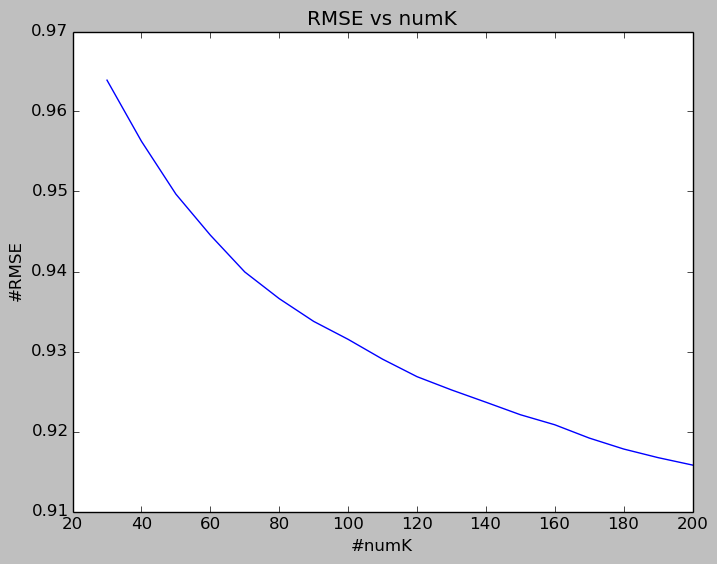

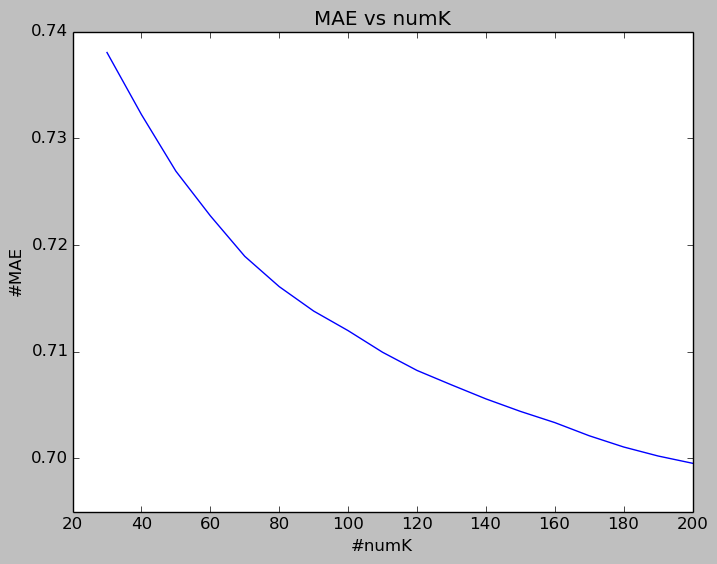

In [16]:
def calcErrorMean(valErrors, variables, seeds):
    ubSumRMSEs, ubSumMAEs = [0]*len(variables), [0]*len(variables)
    for ind in range(len(seeds)):
        tempRMSEs, tempMAEs = [x[0] for x in valErrors[ind]], [x[1] for x in valErrors[ind]]
        for kin in range(len(variables)):
            ubSumRMSEs[kin] += tempRMSEs[kin]
            ubSumMAEs[kin] += tempMAEs[kin]
    avgUbRMSEs = [1.0 * x / len(seeds) for x in ubSumRMSEs]
    avgUbMAEs = [1.0 * x / len(seeds) for x in ubSumMAEs]
    return avgUbRMSEs, avgUbMAEs

avgUbValRMSEs, avgUbValMAEs = calcErrorMean(ubValErrors, top_k, seeds)

plt.figure()
plt.plot(top_k, avgUbValRMSEs)
plt.title('RMSE vs numK')
plt.xlabel('#numK')
plt.ylabel('#RMSE')

plt.figure()
plt.plot(top_k, avgUbValMAEs)
plt.xlabel('#numK')
plt.ylabel('#MAE')
plt.title('MAE vs numK')


### Predict rating score



In [17]:
print "User based approach's performance on test set"

ubTestErrors = [0] * len(seeds)
err = 0
numK = 200# test
for seed in seeds:
    print 'processing with seed %d' % seed
    start_time = time.time()
    trainingRDD, validationRDD, testRDD = ratingsRDD.randomSplit([6, 2, 2], seed=seed)
    testForPredictingRDD = testRDD.map(lambda x: (x[0], x[1]))
    userRatingRDDTrain = trainingRDD.map(lambda x: (x[0], (x[1], x[2]))).groupByKey().cache()
    userRatingAvgBC = broadcastUserRatingAvg(sc, userRatingRDDTrain)
    userMovieHistBC = broadcastUMHist(sc, userRatingRDDTrain)
    cartesianRDD = userRatingRDDTrain.cartesian(userRatingRDDTrain)
    userPairRawRDD = cartesianRDD.filter(lambda (x1, x2): x1[0] < x2[0])
    # ((user_i, user_j), [ratings_of_common_movies])#filter?
    userPairRDD = userPairRawRDD.map(
        lambda (x1, x2): constructCommonRating(x1, x2))#.filter(lambda (x1, x2): len(x2) >= 4)# mark
    # ((user1, user2), (similarity, number of common ratings))
    userSimilarityRDD = userPairRDD.map(lambda x: calcCosineSimilarity(x))
    userSimGroupRDD = userSimilarityRDD.flatMap(lambda x: keyOnUser(x)).groupByKey()
    # userNeighborRDD: (user, [(user_sim, similarity, number of common ratings)])
    userNeighborRDD = userSimGroupRDD.map(lambda (x1, x2): getTopKSimilarUser(x1, x2, 200))
    userNeighborBC = broadcastUNeighborDict(sc, userNeighborRDD)
    predictedRatingsRDD = testForPredictingRDD.map(
            lambda x: predictUserBased(x, userNeighborBC.value, userMovieHistBC.value, userRatingAvgBC.value, numK))
    ubTestErrors[err] = computeErrors(predictedRatingsRDD, testRDD)
    print 'elapsed %s seconds' % (time.time() - start_time)
    err += 1

avgUbTestRMSE = sum([x[0] for x in ubTestErrors]) / float(len(seeds))
avgUbTestMAE = sum([x[1] for x in ubTestErrors]) / float(len(seeds))

print 'User based approach -- numK %s, RMSE on test set: %s' % (numK, avgUbTestRMSE)
print 'User based approach -- numK %s, MAE on test set: %s' % (numK, avgUbTestMAE)

User based approach's performance on test set
processing with seed 0
elapsed 47.8128130436 seconds
processing with seed 1
elapsed 47.4372720718 seconds
processing with seed 2
elapsed 46.9829690456 seconds
processing with seed 3
elapsed 46.7448551655 seconds
processing with seed 4
elapsed 46.8661999702 seconds
processing with seed 5
elapsed 46.9745008945 seconds
processing with seed 6
elapsed 46.9449601173 seconds
processing with seed 7
elapsed 46.6999368668 seconds
processing with seed 8
elapsed 46.9243140221 seconds
processing with seed 9
elapsed 46.8373410702 seconds
User based approach -- numK 200, RMSE on test set: 0.917317317619
User based approach -- numK 200, MAE on test set: 0.701240976192


### Recommend using user-based approach



In [18]:
from collections import defaultdict

def recommendUB(user, neighbors, usermovHistDict, topK = 200, nRec = 30):
    """ User based recommendation
    maintain two dicts, one for similarity sum, one for weighted rating sum
    for every neighbor of a user, get his rated items which hasn't been rated by current user
    then for each movie, sum the weighted rating in the whole neighborhood 
    and sum the similarity of users who rated the movie
    iterate and sort
    Args:
        user: id of a user asking for recommendation
        neighbors: [(user_sim, similarity, number of common ratings)]
        usermovHistDict: (user, ([movie], [rating]))
        topK: the number of neighbors to use
        nRec: the number of recommendation
    """
    simSumDict = defaultdict(float)# similarity sum
    weightedSumDict = defaultdict(float)# weighted rating sum
    movIDUserRated = usermovHistDict.get(user, [])
    for (neighbor, simScore, numCommonRating) in neighbors[:topK]:
        mrlistpair = usermovHistDict.get(neighbor)
        if mrlistpair:
            for index in xrange(0, len(mrlistpair[0])):
                movID = mrlistpair[0][index]
                simSumDict[movID] += simScore
                weightedSumDict[movID] += simScore * mrlistpair[1][index]# sim * rating
    candidates = [(mID, 1.0 * wsum / simSumDict[mID]) for (mID, wsum) in weightedSumDict.iteritems()]
    candidates.sort(key=lambda x: x[1], reverse=True)
    return (user, candidates[:nRec])

def broadcastMovNameDict(sContext, movRDD):
    movieNameList = movRDD.collect()
    movieNameDict = {}
    for (movID, movName) in movieNameList:
        movieNameDict[movID] = movName
    mNameDictBC = sc.broadcast(movieNameDict)
    return mNameDictBC

def genMovRecName(user, records, movNameDict):
    nlist = []
    for record in records:
        nlist.append(movNameDict[record[0]])#userRecomMovNamesRDD
    return (user, nlist)


In [19]:
# use the whole rating dataset
userRatingRDD = ratingsRDD.map(lambda x: (x[0], (x[1], x[2]))).groupByKey()
userRatingAvgBC = broadcastUserRatingAvg(sc, userRatingRDD)
userMovieHistBC = broadcastUMHist(sc, userRatingRDD)
cartesianRDD = userRatingRDD.cartesian(userRatingRDD)
userPairRawRDD = cartesianRDD.filter(lambda (x1, x2): x1[0] < x2[0])
# ((user_i, user_j), [ratings_of_common_movies])#filter?
userPairRDD = userPairRawRDD.map(
    lambda (x1, x2): constructCommonRating(x1, x2))#.filter(lambda (x1, x2): len(x2) >= 4)# mark
# ((user1, user2), (similarity, number of common ratings))
userSimilarityRDD = userPairRDD.map(lambda x: calcCosineSimilarity(x))
userSimGroupRDD = userSimilarityRDD.flatMap(lambda x: keyOnUser(x)).groupByKey()
# userNeighborRDD: (user, [(user_sim, similarity, number of common ratings)])
userNeighborRDD = userSimGroupRDD.map(lambda (x1, x2): getTopKSimilarUser(x1, x2, 200))
userNeighborBC = broadcastUNeighborDict(sc, userNeighborRDD)
userRecomMovIDsRDD = userNeighborRDD.map(lambda (x1, x2): recommendUB(x1, x2, userMovieHistBC.value))
# print 'userRecomMovIDsRDD takes 3: %s' % userRecomMovIDsRDD.take(3)
movieNameDictBC = broadcastMovNameDict(sc, moviesRDD)
userRecomMovNamesRDD = userRecomMovIDsRDD.map(lambda (x1, x2): genMovRecName(x1, x2, movieNameDictBC.value))

print 'Recommend movies using user-based method for user 2: \n'
print userRecomMovNamesRDD.filter(lambda (x1, x2): x1 == 2).collect()

Recommend movies using user-based method for user 2: 

[(2, [u'"Duellists', u'"Caine Mutiny', u'Robot Carnival (Roboto k\xe2nibauru) (1987)', u'Safe Passage (1994)', u'"Butcher', u'Shame (2011)', u'Clean Slate (1994)', u'Song of the Little Road (Pather Panchali) (1955)', u'Our Music (Notre musique) (2004)', u"Bush's Brain (2004)", u'Supercop (Police Story 3: Supercop) (Jing cha gu shi III: Chao ji jing cha) (1992)', u'Meet Me in St. Louis (1944)', u'"Roaring Twenties', u'Ministry of Fear (1944)', u'Vampire in Venice (Nosferatu a Venezia) (Nosferatu in Venice) (1986)', u'Unfaithfully Yours (1948)', u"Some Mother's Son (1996)", u'Grateful Dead (1995)', u'"Winter Guest', u'Harlan County U.S.A. (1976)', u'Character (Karakter) (1997)', u'"Baader Meinhof Komplex', u'Steamboat Willie (1928)', u'Autumn Sonata (H\xf6stsonaten) (1978)', u'Dancing at Lughnasa (1998)', u'Central Station (Central do Brasil) (1998)', u'Pusher (1996)', u'Nothing in Common (1986)', u'"Last Days', u'"Lovers on the Brid

## Collaborative Filtering Using MLlib ALS



In [20]:
from pyspark.mllib.recommendation import ALS

sc.setCheckpointDir('checkpoint/')
# Set the directory under which RDDs are going to be checkpointed. 
# The directory must be a HDFS path if running on a cluster.

### Tune Hyperparameters



In [21]:
iterations = 20
regularizationParameter = 0.12#0.1
ranks = range(2, 15, 1)
rankValErrors = [0] * len(seeds)
err = 0

for seed in seeds:
    trainingRDD, validationRDD, testRDD = ratingsRDD.randomSplit([6, 2, 2], seed=seed)
    valForPredictRDD = validationRDD.map(lambda x: (x[0], x[1])).cache()
    start_time = time.time()
    tempErrors = []
    for rank in ranks:
        model = ALS.train(trainingRDD, rank, seed=seed, iterations=iterations,
                          lambda_=regularizationParameter)
        predictedRatingsRDD = model.predictAll(valForPredictRDD)
        error = computeErrors(predictedRatingsRDD, validationRDD)
        tempErrors.append(error)
    rankValErrors[err] = tempErrors
    err += 1
    print 'processing with seed %d elapsed %s seconds' % (seed, (time.time() - start_time))


processing with seed 0 elapsed 53.5086989403 seconds
processing with seed 1 elapsed 47.8036849499 seconds
processing with seed 2 elapsed 47.8026862144 seconds
processing with seed 3 elapsed 47.1010839939 seconds
processing with seed 4 elapsed 47.3174259663 seconds
processing with seed 5 elapsed 47.2495648861 seconds
processing with seed 6 elapsed 47.0170087814 seconds
processing with seed 7 elapsed 47.2025249004 seconds
processing with seed 8 elapsed 47.5975828171 seconds
processing with seed 9 elapsed 50.6183440685 seconds


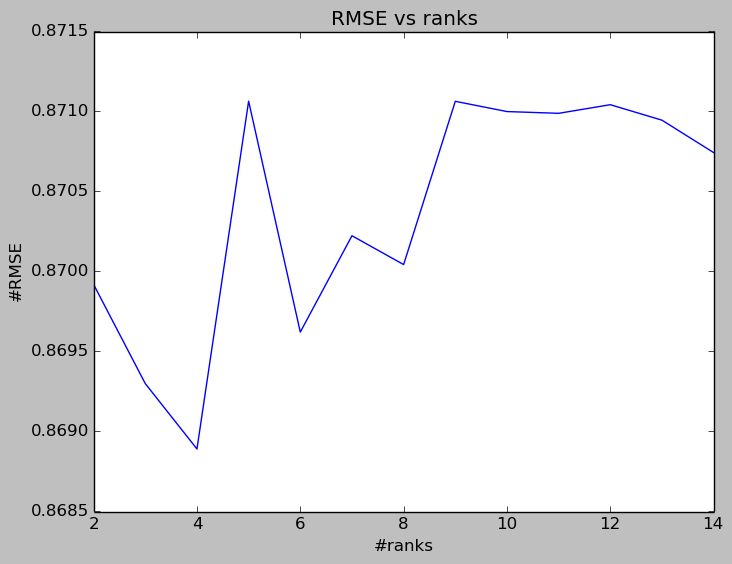

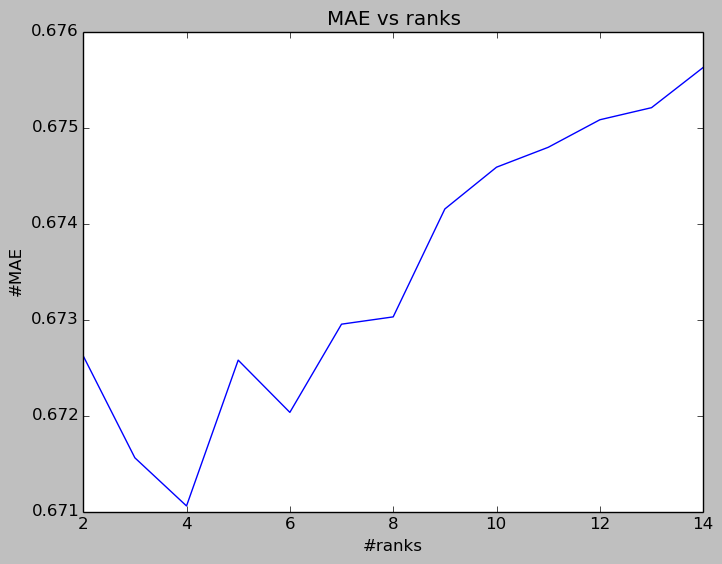

In [22]:

avgRankValRMSEs, avgRankValMAEs = calcErrorMean(rankValErrors, ranks, seeds)

plt.figure()
plt.plot(ranks, avgRankValRMSEs)
plt.title('RMSE vs ranks')
plt.xlabel('#ranks')
plt.ylabel('#RMSE')

plt.figure()
plt.plot(ranks, avgRankValMAEs)
plt.xlabel('#ranks')
plt.ylabel('#MAE')
plt.title('MAE vs ranks')

In [23]:
iterations = range(8, 31)
regularizationParameter = 0.12
rank = 4#bestRank
iterValErrors = [0] * len(seeds)
err = 0

for seed in seeds:
    trainingRDD, validationRDD, testRDD = ratingsRDD.randomSplit([6, 2, 2], seed=seed)
    valForPredictRDD = validationRDD.map(lambda x: (x[0], x[1])).cache()
    start_time = time.time()
    tempErrors = []
    for iterNum in iterations:
        model = ALS.train(trainingRDD, rank, seed=seed, iterations=iterNum,
                          lambda_=regularizationParameter)
        predictedRatingsRDD = model.predictAll(valForPredictRDD)
        error = computeErrors(predictedRatingsRDD, validationRDD)
        tempErrors.append(error)
    iterValErrors[err] = tempErrors
    err += 1
    print 'processing with seed %d elapsed %s seconds' % (seed, (time.time() - start_time))


processing with seed 0 elapsed 77.2842440605 seconds
processing with seed 1 elapsed 79.4855570793 seconds
processing with seed 2 elapsed 80.5634021759 seconds
processing with seed 3 elapsed 74.1923921108 seconds
processing with seed 4 elapsed 74.2313477993 seconds
processing with seed 5 elapsed 74.4901628494 seconds
processing with seed 6 elapsed 74.2786440849 seconds
processing with seed 7 elapsed 74.8586030006 seconds
processing with seed 8 elapsed 80.8597249985 seconds
processing with seed 9 elapsed 83.9975781441 seconds


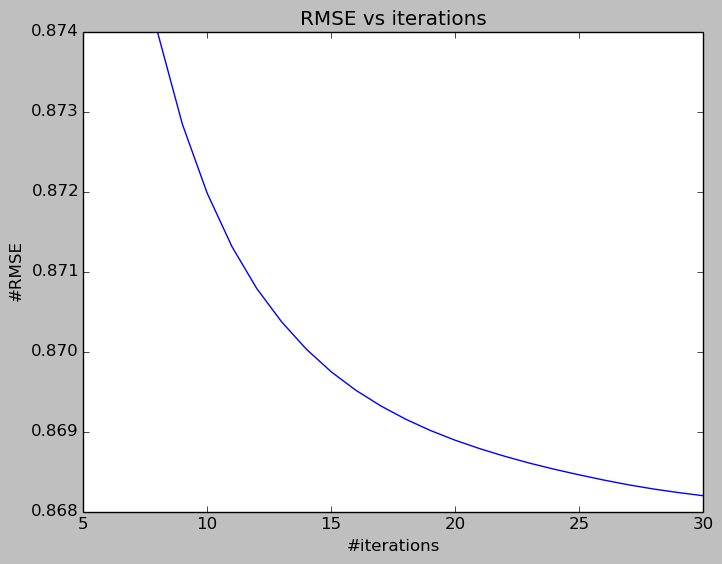

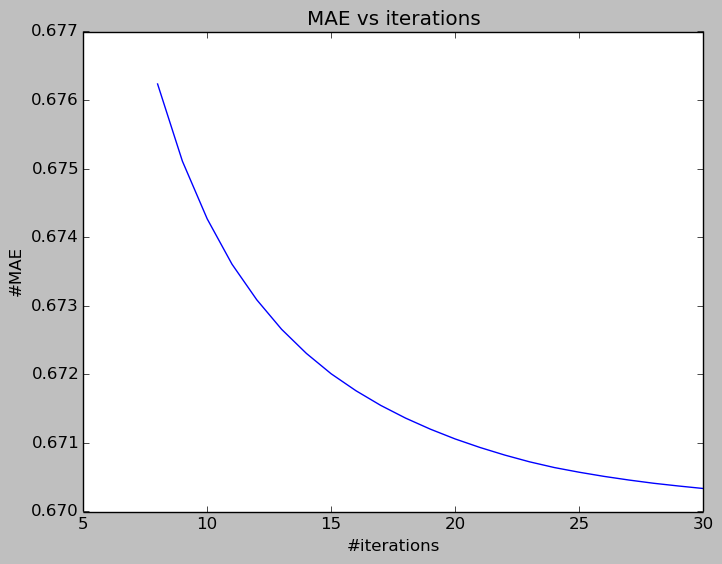

In [24]:

avgIterValRMSEs, avgIterValMAEs = calcErrorMean(iterValErrors, iterations, seeds)

plt.figure()
plt.plot(iterations, avgIterValRMSEs)
plt.title('RMSE vs iterations')
plt.xlabel('#iterations')
plt.ylabel('#RMSE')

plt.figure()
plt.plot(iterations, avgIterValMAEs)
plt.xlabel('#iterations')
plt.ylabel('#MAE')
plt.title('MAE vs iterations')


### Performance on test sets



In [25]:

mfTestErrors = [0] * len(seeds)
err = 0
iterations = 20
bestRank = 4
for seed in seeds:
    start_time = time.time()
    trainingRDD, validationRDD, testRDD = ratingsRDD.randomSplit([6, 2, 2], seed=seed)
    testForPredictingRDD = testRDD.map(lambda x: (x[0], x[1]))
    model = ALS.train(trainingRDD, bestRank, seed=seed, iterations=iterations,
                          lambda_=regularizationParameter)
    predictedTestRDD = model.predictAll(testForPredictingRDD)
    error = computeErrors(testRDD, predictedTestRDD)
    mfTestErrors[err] = error
    print 'processing with seed %d elapsed %s seconds' % (seed, (time.time() - start_time))
    err += 1

avgMfTestRMSE = sum([x[0] for x in mfTestErrors]) / float(len(seeds))
avgMfTestMAE = sum([x[1] for x in mfTestErrors]) / float(len(seeds))

print 'Matrix factorization approach -- rank %s, #iterations %s, RMSE on test set: %s' % (
    bestRank, iterations, avgMfTestRMSE)
print 'Matrix factorization approach -- rank %s, #iterations %s, MAE on test set: %s' % (
    bestRank, iterations, avgMfTestMAE)


processing with seed 0 elapsed 3.57687211037 seconds
processing with seed 1 elapsed 3.40865707397 seconds
processing with seed 2 elapsed 3.61715507507 seconds
processing with seed 3 elapsed 3.25584888458 seconds
processing with seed 4 elapsed 3.24436593056 seconds
processing with seed 5 elapsed 3.3850338459 seconds
processing with seed 6 elapsed 3.36685204506 seconds
processing with seed 7 elapsed 3.47407007217 seconds
processing with seed 8 elapsed 3.23478198051 seconds
processing with seed 9 elapsed 3.22149991989 seconds
Matrix factorization approach -- rank 4, #iterations 20, RMSE on test set: 0.872306085756
Matrix factorization approach -- rank 4, #iterations 20, MAE on test set: 0.674700845291


### Recommend



In [26]:
# use the whole rating dataset
import shutil

# save the model
modelPath = os.path.join('models', 'movie_ALS')
if os.path.exists(modelPath):
    # os.getcwd()
    shutil.rmtree(modelPath)

bestModel = ALS.train(ratingsRDD, bestRank, seed=seed, iterations=iterations,
                          lambda_=regularizationParameter)
bestModel.save(sc, modelPath)

In [27]:
def getCounts(IDandRatingsTuple):
    """ Calculate average rating
    Args:
        IDandRatingsTuple: a single tuple of (MovieID, (Rating1, Rating2, Rating3, ...))
    Returns:
        tuple: a tuple of (MovieID, number of ratings)
    """
    return (IDandRatingsTuple[0], len(IDandRatingsTuple[1]))

# movRatingCntRDD: (movID, number of ratings)
movRatingCntRDD = movIDRatingsRDD.map(getCounts)
# print 'movRatingCntRDD: %s\n' % movRatingCntRDD.take(3)

# movIDNameCntRDD: (movID, (movName, number of ratings))
movIDNameCntRDD = movRatingCntRDD.join(moviesRDD).map(
    lambda x: (x[0], (x[1][1], x[1][0]))).cache()
# print 'movIDNameCntRDD: %s\n' % movIDNameCntRDD.take(3)


In [28]:

def recommendALS(user, model, movieRDD, usermovHistDict, movIDNameCntRDD, nRec = 30, ratedThreshold = 20):
    """ Recommend for a user
        usermovHistDict: (user:([movie], [rating]))
    """
    userUnratedRDD = movieRDD.flatMap(
        lambda (movID, movName): [(user, movID)] if movID not in usermovHistDict[user][0] else []).cache()
    # if not cache userUnratedRDD, might have IOError, could not find the /tmp/blablabla directory or file...
    # don't know why yet...
    predUserRDD = model.predictAll(userUnratedRDD).map(lambda x: (x[1], x[2]))# (Movie ID, Predicted Rating)
    # after join in the expression below, we get something like: (40962, (2.184925882635273, (u'"Yours', 3)))
    # we want to get (Predicted Rating, Movie Name, number of ratings)
    return predUserRDD.join(movIDNameCntRDD).map(
        lambda (x1, x2): (x2[0], x2[1][0], x2[1][1])).filter(
        lambda x: x[2] > ratedThreshold).takeOrdered(nRec, key=lambda x: -x[0])

# load model if necessary
from pyspark.mllib.recommendation import MatrixFactorizationModel
modelPath = os.path.join('models', 'movie_ALS')
try:
    bestModel
except NameError:
    bestModel = MatrixFactorizationModel.load(sc, modelPath)

print ('Recommend for user %s (movies with more than 20 ratings):\n%s' % (2, 
        '\n'.join(map(str, recommendALS(2, bestModel, moviesRDD, userMovieHistBC.value, movIDNameCntRDD, 30, 20)))))

Recommend for user 2 (movies with more than 20 ratings):
(4.411707760203285, u'Seven Samurai (Shichinin no samurai) (1954)', 233)
(4.400843232453608, u'Ikiru (1952)', 21)
(4.374843980304517, u'"Shawshank Redemption', 992)
(4.369034273750421, u'Sanjuro (Tsubaki Sanj\xfbr\xf4) (1962)', 34)
(4.363376791444295, u'"Spring', 30)
(4.348539600701806, u'Yojimbo (1961)', 75)
(4.30238685762288, u'Louis C.K.: Shameless (2007)', 22)
(4.277562794742607, u'Modern Times (1936)', 57)
(4.270019500839576, u'Show Me Love (Fucking \xc5m\xe5l) (1998)', 33)
(4.253951979375141, u'"Night at the Opera', 30)
(4.247372277529772, u'"Hustler', 81)
(4.236945059350214, u'"Great Dictator', 78)
(4.236449474086161, u'My Life in Pink (Ma vie en rose) (1997)', 38)
(4.227426692308724, u'"Killer', 53)
(4.225867563583995, u'"Devil\'s Backbone', 24)
(4.225333816417605, u'"Silence of the Lambs', 1039)
(4.213732290711391, u"One Flew Over the Cuckoo's Nest (1975)", 531)
(4.210004559922725, u'"Dreamers', 22)
(4.202232684063517, u